### Importação das Bibliotecas que serão utilizadas no Modelo

### Aqui segue o pré-processamento e o que foi feito nas Sprints 1 e 2

In [1]:
!pip install --upgrade tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.6 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [2]:
!pip install meteostat

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import gdown
import plotly.express as px
import plotly.graph_objects as go
from tensorflow.keras import backend as K
from sklearn.cluster import KMeans
from pathlib import Path
import plotly.graph_objects as go
from meteostat import Point, Daily
from datetime import datetime

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Download dos arquivos contendo os datasets de consumo desde 2019 a 2024
  - Aqui retiramos a base de 2020, por conta da pandemia do Coronavírus. Foi uma escolha do grupo devido à possibilidade de discrepância nas leituras

In [5]:
arquivo_destino_base = "dataset_{}.csv"

ids = {
    "consumo_2024": "1-iXT7eaJWQokHf9cyfrB8N5wvkdhgjJW",
    "consumo_2023": "1-WfvkRwaRr85B_Joxcm9xVdpyg5NBAmp",
    "consumo_2022": "1-Uu4Tf4lufJVFeJnYKc5w7OeW66pe1eC",
    "consumo_2021": "1-2PsTLzG4dcY4wM0p7vFfabUuLv950gC",
    # "consumo_2020": "1-1pOoa0eJlNJ94BMi7p4PTx5KUS96mhX",
    "consumo_2019": "1-2PsTLzG4dcY4wM0p7vFfabUuLv950gC",
    "CONSUMO_GERAL": "1-IOqfwmh_tTIDHeOer8J-HkGFtwuX67g",
}


dataframes = {}


for key, file_id in ids.items():
    url = f"https://drive.google.com/uc?id={file_id}"
    arquivo_destino = arquivo_destino_base.format(key)

    gdown.download(url, arquivo_destino, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1-iXT7eaJWQokHf9cyfrB8N5wvkdhgjJW
From (redirected): https://drive.google.com/uc?id=1-iXT7eaJWQokHf9cyfrB8N5wvkdhgjJW&confirm=t&uuid=7131bd49-9371-4e89-8316-b26f2b03d66a
To: /content/dataset_consumo_2024.csv
100%|██████████| 668M/668M [00:05<00:00, 118MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1-WfvkRwaRr85B_Joxcm9xVdpyg5NBAmp
From (redirected): https://drive.google.com/uc?id=1-WfvkRwaRr85B_Joxcm9xVdpyg5NBAmp&confirm=t&uuid=198b1df2-232c-45a2-938e-328fd224cda4
To: /content/dataset_consumo_2023.csv
100%|██████████| 1.09G/1.09G [00:15<00:00, 71.9MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1-Uu4Tf4lufJVFeJnYKc5w7OeW66pe1eC
From (redirected): https://drive.google.com/uc?id=1-Uu4Tf4lufJVFeJnYKc5w7OeW66pe1eC&confirm=t&uuid=1a8c90b8-7775-4b4c-9785-f55355ebe88e
To: /content/dataset_consumo_2022.csv
100%|██████████| 1.07G/1.07G [00:08<00:00, 127MB/s]
Downloading...
From (original): 

In [6]:
arquivos_csv = [
    "./dataset_consumo_2024.csv",
    "./dataset_consumo_2023.csv",
    "./dataset_consumo_2022.csv",
    "./dataset_consumo_2021.csv",
    "./dataset_consumo_2019.csv",
]

ALL_COLUMNS_CONSUMO_GERAL = pd.concat([pd.read_csv(arquivo, delimiter=";") for arquivo in arquivos_csv], axis=0)

In [7]:
consumo_geral = pd.read_csv('/content/dataset_CONSUMO_GERAL.csv')

## Download do dataset com o Target das Fraudes

In [8]:
file_id_fraudes = "1-MbIlChqQapcxFkoJgpbQIsN9FBLfbX1"
url_fraudes = f"https://drive.google.com/uc?id={file_id_fraudes}"

gdown.download(url_fraudes, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1-MbIlChqQapcxFkoJgpbQIsN9FBLfbX1
To: /content/fraudes.csv
100%|██████████| 55.0M/55.0M [00:00<00:00, 73.9MB/s]


'fraudes.csv'

In [9]:
fraudes = pd.read_csv('/content/fraudes.csv')

## Mexendo no dataframe

### A tabela "ALL_COLUMNS_CONSUMO_GERAL" possui todas as tabelas de consumo e a partir disso decidimos considerar algumas colunas categóricas que podem ajudar a melhorar o desempenho do nosso modelo

In [10]:
ALL_COLUMNS_CONSUMO_GERAL.columns.values

array(['Unnamed: 0', 'EMP_CODIGO', 'REFERENCIA', 'COD_GRUPO',
       'COD_SETOR_COMERCIAL', 'NUM_QUADRA', 'COD_ROTA_LEITURA',
       'MATRICULA', 'SEQ_RESPONSAVEL', 'ECO_RESIDENCIAL', 'ECO_COMERCIAL',
       'ECO_INDUSTRIAL', 'ECO_PUBLICA', 'ECO_OUTRAS', 'LTR_ATUAL',
       'LTR_COLETADA', 'DAT_LEITURA', 'DIAS_LEITURA', 'CONS_MEDIDO',
       'TIPO_LIGACAO', 'CATEGORIA', 'SUB_CATEGORIA', 'DSC_OCORRENCIA',
       'COD_LEITURA_INF_1', 'COD_LEITURA_INF_2', 'COD_LEITURA_INF_3',
       'HORA_LEITURA', 'DSC_SIMULTANEA', 'VOLUME_ESTIMADO',
       'VOLUME_ESTIMADO_ACUM', 'FATURADO_MEDIA', 'COD_LEITURA_INT',
       'STA_TROCA', 'EXCECAO', 'STA_ACEITA_LEITURA', 'COD_LATITUDE',
       'COD_LONGITUDE'], dtype=object)

In [11]:
ALL_COLUMNS_CONSUMO_GERAL

,Unnamed: 0,EMP_CODIGO,REFERENCIA,COD_GRUPO,COD_SETOR_COMERCIAL,NUM_QUADRA,COD_ROTA_LEITURA,MATRICULA,SEQ_RESPONSAVEL,ECO_RESIDENCIAL,...,DSC_SIMULTANEA,VOLUME_ESTIMADO,VOLUME_ESTIMADO_ACUM,FATURADO_MEDIA,COD_LEITURA_INT,STA_TROCA,EXCECAO,STA_ACEITA_LEITURA,COD_LATITUDE,COD_LONGITUDE
0,0,2.0,2024-05-01,4.0,17.0,16.0,11.0,17188010.0,581756.0,0.0,...,63-RETIDA - FATURA ELETRONICA,-21.0,0.0,NaN,901.0,N,Normal,S,-20.460904,-54.634308
1,1,2.0,2024-06-01,4.0,87.0,60.0,38.0,17424465.0,188809.0,1.0,...,00-NAO ENTREGUE,0.0,0.0,NaN,900.0,N,Normal,S,-20.520205,-54.602621
2,2,2.0,2024-07-01,14.0,85.0,314.0,9.0,17857770.0,454315.0,1.0,...,00-NAO ENTREGUE,0.0,0.0,NaN,900.0,N,Normal,S,-20.517992,-54.605950
3,3,2.0,2024-03-01,8.0,5.0,112.0,25.0,17702922.0,311133.0,0.0,...,04-FIXADA AO PORTAO,0.0,0.0,NaN,900.0,N,Normal,S,-20.453648,-54.611187
4,4,2.0,2024-01-01,12.0,88.0,284.0,43.0,17719490.0,735648.0,1.0,...,02-CAIXA CORREIO,-9.0,0.0,NaN,901.0,N,Normal,S,-20.516981,-54.592872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4210815,4210815,2.0,2019-11-01,12.0,8.0,271.0,4.0,17108333.0,1049413.0,1.0,...,02-CAIXA CORREIO,10.0,10.0,MEDIA,107.0,N,Normal,N,-20.469254,-54.597804
4210816,4210816,2.0,2019-11-01,9.0,92.0,330.0,47.0,17171758.0,886058.0,1.0,...,04-FIXADA AO PORTAO,10.0,10.0,MEDIA,107.0,N,Normal,N,-20.550235,-54.573375
4210817,4210817,2.0,2019-11-01,11.0,38.0,416.0,20.0,17779236.0,262062.0,1.0,...,02-CAIXA CORREIO,10.0,10.0,MEDIA,104.0,N,Normal,N,-20.438123,-54.666558
4210818,4210818,2.0,2019-04-01,16.0,3.0,76.0,1.0,17338320.0,167787.0,0.0,...,10-ISENTA - NAO IMPRESSA,0.0,0.0,NaN,900.0,N,Normal,S,-20.456004,-54.596311


In [12]:
def cortandoData(df, startAno, startMes, endAno, endMes):
    start_date = f'{startAno}-{str(startMes).zfill(2)}-01'
    end_date = f'{endAno}-{str(endMes).zfill(2)}-01'

    df['REFERENCIA'] = pd.to_datetime(df['REFERENCIA'], format='%Y-%m-%d')

    # Filtrando o DataFrame pela janela de tempo
    mask = (df['REFERENCIA'] >= start_date) & (df['REFERENCIA'] <= end_date)
    df_filtered = df.loc[mask]

    return df_filtered

ALL_COLUMNS_CONSUMO_GERAL = cortandoData(ALL_COLUMNS_CONSUMO_GERAL, 2022, 1, 2024, 1)

### Remoção de colunas indesejadas até o momento

In [13]:
ALL_COLUMNS_CONSUMO_GERAL = ALL_COLUMNS_CONSUMO_GERAL.drop(columns=['Unnamed: 0', 'EMP_CODIGO', 'COD_GRUPO', 'COD_SETOR_COMERCIAL', 'NUM_QUADRA', 'COD_ROTA_LEITURA', 'SEQ_RESPONSAVEL', 'ECO_RESIDENCIAL', 'ECO_OUTRAS','LTR_ATUAL', 'LTR_COLETADA', 'DAT_LEITURA', 'DIAS_LEITURA', 'COD_LEITURA_INF_1', 'COD_LEITURA_INF_2', 'COD_LEITURA_INF_3', 'HORA_LEITURA', 'DSC_SIMULTANEA', 'COD_LEITURA_INT','EXCECAO'])

In [14]:
ALL_COLUMNS_CONSUMO_GERAL.columns

Index(['REFERENCIA', 'MATRICULA', 'ECO_COMERCIAL', 'ECO_INDUSTRIAL',
       'ECO_PUBLICA', 'CONS_MEDIDO', 'TIPO_LIGACAO', 'CATEGORIA',
       'SUB_CATEGORIA', 'DSC_OCORRENCIA', 'VOLUME_ESTIMADO',
       'VOLUME_ESTIMADO_ACUM', 'FATURADO_MEDIA', 'STA_TROCA',
       'STA_ACEITA_LEITURA', 'COD_LATITUDE', 'COD_LONGITUDE'],
      dtype='object')

### Nessa seção queriamos validar a tabela de "VOLUME_ESTIMADO_ACUM" para ver se ela poderia agregar dentro do nosso modelo

In [15]:
ALL_COLUMNS_CONSUMO_GERAL[['VOLUME_ESTIMADO_ACUM']].nunique()

,0
VOLUME_ESTIMADO_ACUM,702


In [16]:
ALL_COLUMNS_CONSUMO_GERAL[ALL_COLUMNS_CONSUMO_GERAL['VOLUME_ESTIMADO'] != 0]

,REFERENCIA,MATRICULA,ECO_COMERCIAL,ECO_INDUSTRIAL,ECO_PUBLICA,CONS_MEDIDO,TIPO_LIGACAO,CATEGORIA,SUB_CATEGORIA,DSC_OCORRENCIA,VOLUME_ESTIMADO,VOLUME_ESTIMADO_ACUM,FATURADO_MEDIA,STA_TROCA,STA_ACEITA_LEITURA,COD_LATITUDE,COD_LONGITUDE
4,2024-01-01,17719490.0,0.0,0.0,0.0,20.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,NORMAL,-9.0,0.0,NaN,N,S,-20.516981,-54.592872
10,2024-01-01,17369705.0,0.0,0.0,0.0,21.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,NORMAL,-8.0,0.0,NaN,N,S,-20.485598,-54.595796
16,2024-01-01,17711208.0,0.0,0.0,0.0,28.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,NORMAL,-14.0,0.0,NaN,N,S,-20.502230,-54.670333
22,2024-01-01,17105583.0,0.0,0.0,0.0,11.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,NORMAL,-5.0,0.0,NaN,N,S,-20.477354,-54.611138
28,2024-01-01,17130214.0,0.0,0.0,0.0,37.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,NORMAL,-14.0,0.0,NaN,N,S,-20.448479,-54.611124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4492142,2022-03-01,17172838.0,0.0,0.0,0.0,0.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,MEDIDOR DE DIFÍCIL ACESSO,15.0,30.0,MEDIA,N,N,-20.554927,-54.577706
4492143,2022-03-01,17977627.0,0.0,0.0,0.0,0.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,MEDIDOR DE DIFÍCIL ACESSO,1.0,1.0,MEDIA,N,N,-20.508637,-54.647928
4492144,2022-03-01,17972199.0,0.0,0.0,0.0,0.0,Hidrometrado,RESIDENCIAL,RES. SOCIAL,MEDIDOR DE DIFÍCIL ACESSO,1.0,1.0,MEDIA,N,N,-20.547528,-54.622010
4492145,2022-03-01,17970540.0,0.0,0.0,0.0,0.0,Hidrometrado,RESIDENCIAL,RES. SOCIAL,MEDIDOR DE DIFÍCIL ACESSO,1.0,1.0,MEDIA,N,N,-20.546470,-54.622029


#### O insight retirado aqui é que talvez a melhor coluna para validação e ser utilizada como featura no modelo é a coluna de Volume Estimado. Ela possui maior consistência nos resultados, do que a coluna de Volume Estimado Acumulado

## Tempetura

In [17]:
# Define a localização geográfica: Campo Grande MT
location = Point(-20.4435, -54.6478)

# Define o intervalo de datas
start = datetime(2022, 1, 1)
end = datetime(2024, 1, 1)

# Busca os dados diários de clima para a localização e período definidos
data = Daily(location, start, end)
data = data.fetch()

# Calcula a média mensal dos dados climáticos
df_mes_weather = data.resample('M').mean()

# Renomeia as colunas do DataFrame para termos mais descritivos em português
df_weather_22_23 = df_mes_weather.rename(columns={
    'tavg': 'Temperatura Média',
    'tmin': 'Temperatura Mínima',
    'tmax': 'Temperatura Máxima',
    'prcp': 'Precipitação',
    'snow': 'Neve',
    'wdir': 'Direção do Vento',
    'wspd': 'Velocidade do Vento',
    'wpgt': 'Rajada Máxima de Vento',
    'pres': 'Pressão Atmosférica',
    'tsun': 'Insolação'
})

In [18]:
df_weather_22_23 = df_mes_weather.drop(['Neve',	'Direção do Vento', 'Velocidade do Vento',	'Rajada Máxima de Vento', 'Pressão Atmosférica',	'Insolação', 'Temperatura Mínima', 'Temperatura Máxima'], axis=1)
df_weather_22_23

KeyError: "['Neve', 'Direção do Vento', 'Velocidade do Vento', 'Rajada Máxima de Vento', 'Pressão Atmosférica', 'Insolação', 'Temperatura Mínima', 'Temperatura Máxima'] not found in axis"

In [19]:
ALL_COLUMNS_CONSUMO_GERAL['REFERENCIA'] = pd.to_datetime(ALL_COLUMNS_CONSUMO_GERAL['REFERENCIA'])

ALL_COLUMNS_CONSUMO_GERAL['MES'] = ALL_COLUMNS_CONSUMO_GERAL['REFERENCIA'].dt.month

df_weather_22_23['MES'] = df_weather_22_23.index.month

# Agrupa os dados por mês e calcula a média do consumo medido ('CONS_MEDIDO') para cada mês
consumo_medio_23 = ALL_COLUMNS_CONSUMO_GERAL.groupby('MES')['CONS_MEDIDO'].mean().reset_index()

# Combina os dados de consumo médio com os dados meteorológicos com base na coluna 'MES'
ALL_COLUMNS_CONSUMO_GERAL = pd.merge(ALL_COLUMNS_CONSUMO_GERAL, df_weather_22_23, on='MES')

### Separação de Features relevantes

Após pesquisas e visualizar as colunas disponíveis, percebemos uma coluna que poderia ser interessante para o processo de identificação de fraude. A coluna de "DSC_OCORRENCIA". Ela basicamente corresponde a descrição de como foi o processo de vistoria e coleta do responsável e em cada um dos domicílios (matrícula)

Isso surgiu como uma possibilidade de tentar direcionar o modelo para casos nos quais há uma maior possibilidade de uma fraude, de acordo com a visualização do medidor em cada um desses domicílios.

In [20]:
ALL_COLUMNS_CONSUMO_GERAL_PREMISSA_VINI = ALL_COLUMNS_CONSUMO_GERAL[ALL_COLUMNS_CONSUMO_GERAL['DSC_OCORRENCIA'].isin([
    'NORMAL',
    'MEDIDOR RETIRADO/FURTADO',
    'LEITURA COLETADA PELO CLIENTE',
    'MEDIDOR NÃO LOCALIZADO',
    'IMÓVEL DESOCUPADO',
    'HIDRÔMETRO COM CÚPULA VIRADA/TAMPADA',
    'CAIXA DE PROTEÇÃO FECHADA',
    'IMÓVEL A ALUGAR/VENDA'
    'LIGAÇÃO NÃO LOCALIZADA'
    'FRAUDE IDENTIFICADA'
    'MEDIDOR COM DEFEITO/PARADO'
])]

ALL_COLUMNS_CONSUMO_GERAL_PREMISSA_VINI

,REFERENCIA,MATRICULA,ECO_COMERCIAL,ECO_INDUSTRIAL,ECO_PUBLICA,CONS_MEDIDO,TIPO_LIGACAO,CATEGORIA,SUB_CATEGORIA,DSC_OCORRENCIA,...,Temperatura Média,Temperatura Mínima,Temperatura Máxima,Precipitação,Neve,Direção do Vento,Velocidade do Vento,Rajada Máxima de Vento,Pressão Atmosférica,Insolação
0,2024-01-01,17719490.0,0.0,0.0,0.0,20.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,NORMAL,...,27.229032,23.332258,32.103226,4.332258,NaN,313.096774,10.100000,NaN,1009.667742,NaN
1,2024-01-01,17719490.0,0.0,0.0,0.0,20.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,NORMAL,...,26.722581,23.161290,31.077419,4.932258,NaN,299.032258,10.309677,NaN,1010.664516,NaN
2,2024-01-01,17719490.0,0.0,0.0,0.0,20.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,NORMAL,...,26.800000,24.300000,29.900000,8.000000,NaN,360.000000,9.100000,NaN,1010.200000,NaN
3,2024-01-01,17369705.0,0.0,0.0,0.0,21.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,NORMAL,...,27.229032,23.332258,32.103226,4.332258,NaN,313.096774,10.100000,NaN,1009.667742,NaN
4,2024-01-01,17369705.0,0.0,0.0,0.0,21.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,NORMAL,...,26.722581,23.161290,31.077419,4.932258,NaN,299.032258,10.309677,NaN,1010.664516,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20035854,2022-03-01,17248605.0,0.0,0.0,0.0,0.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,MEDIDOR NÃO LOCALIZADO,...,27.003226,23.122581,31.841935,5.796774,NaN,256.774194,8.319355,NaN,1012.729032,NaN
20035861,2022-03-01,17117769.0,0.0,0.0,0.0,0.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,IMÓVEL DESOCUPADO,...,27.116129,23.287097,31.951613,4.609677,NaN,276.516129,8.751613,NaN,1011.900000,NaN
20035862,2022-03-01,17117769.0,0.0,0.0,0.0,0.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,IMÓVEL DESOCUPADO,...,27.003226,23.122581,31.841935,5.796774,NaN,256.774194,8.319355,NaN,1012.729032,NaN
20035869,2022-03-01,17972828.0,0.0,0.0,0.0,0.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,MEDIDOR RETIRADO/FURTADO,...,27.116129,23.287097,31.951613,4.609677,NaN,276.516129,8.751613,NaN,1011.900000,NaN


## Tratando Dataframe com mais colunas targets adicionadas

#### Seperação do Dataframe apenas para a visualização das matriculas com Categoria Pessoa Jurídica

In [21]:
dataframe_pj_premissa = ALL_COLUMNS_CONSUMO_GERAL_PREMISSA_VINI[ALL_COLUMNS_CONSUMO_GERAL_PREMISSA_VINI["CATEGORIA"].isin(["COMERCIAL", "PUBLICA", "INDUSTRIAL"])]
dataframe_pj_premissa

,REFERENCIA,MATRICULA,ECO_COMERCIAL,ECO_INDUSTRIAL,ECO_PUBLICA,CONS_MEDIDO,TIPO_LIGACAO,CATEGORIA,SUB_CATEGORIA,DSC_OCORRENCIA,...,Temperatura Média,Temperatura Mínima,Temperatura Máxima,Precipitação,Neve,Direção do Vento,Velocidade do Vento,Rajada Máxima de Vento,Pressão Atmosférica,Insolação
312,2024-01-01,17835219.0,1.0,0.0,0.0,0.0,Hidrometrado,COMERCIAL,COMERCIAL,NORMAL,...,27.229032,23.332258,32.103226,4.332258,NaN,313.096774,10.100000,NaN,1009.667742,NaN
313,2024-01-01,17835219.0,1.0,0.0,0.0,0.0,Hidrometrado,COMERCIAL,COMERCIAL,NORMAL,...,26.722581,23.161290,31.077419,4.932258,NaN,299.032258,10.309677,NaN,1010.664516,NaN
314,2024-01-01,17835219.0,1.0,0.0,0.0,0.0,Hidrometrado,COMERCIAL,COMERCIAL,NORMAL,...,26.800000,24.300000,29.900000,8.000000,NaN,360.000000,9.100000,NaN,1010.200000,NaN
315,2024-01-01,17775660.0,1.0,0.0,0.0,0.0,Hidrometrado,COMERCIAL,COMERCIAL,NORMAL,...,27.229032,23.332258,32.103226,4.332258,NaN,313.096774,10.100000,NaN,1009.667742,NaN
316,2024-01-01,17775660.0,1.0,0.0,0.0,0.0,Hidrometrado,COMERCIAL,COMERCIAL,NORMAL,...,26.722581,23.161290,31.077419,4.932258,NaN,299.032258,10.309677,NaN,1010.664516,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20035780,2022-03-01,17106914.0,1.0,0.0,0.0,0.0,Hidrometrado,COMERCIAL,COMERCIAL,MEDIDOR RETIRADO/FURTADO,...,27.003226,23.122581,31.841935,5.796774,NaN,256.774194,8.319355,NaN,1012.729032,NaN
20035807,2022-03-01,17197853.0,1.0,0.0,0.0,0.0,Hidrometrado,COMERCIAL,COMERCIAL,CAIXA DE PROTEÇÃO FECHADA,...,27.116129,23.287097,31.951613,4.609677,NaN,276.516129,8.751613,NaN,1011.900000,NaN
20035808,2022-03-01,17197853.0,1.0,0.0,0.0,0.0,Hidrometrado,COMERCIAL,COMERCIAL,CAIXA DE PROTEÇÃO FECHADA,...,27.003226,23.122581,31.841935,5.796774,NaN,256.774194,8.319355,NaN,1012.729032,NaN
20035817,2022-03-01,17132023.0,1.0,0.0,0.0,0.0,Hidrometrado,COMERCIAL,COMERCIAL,HIDRÔMETRO COM CÚPULA VIRADA/TAMPADA,...,27.116129,23.287097,31.951613,4.609677,NaN,276.516129,8.751613,NaN,1011.900000,NaN


<ipython-input-30-de1b520f446f>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



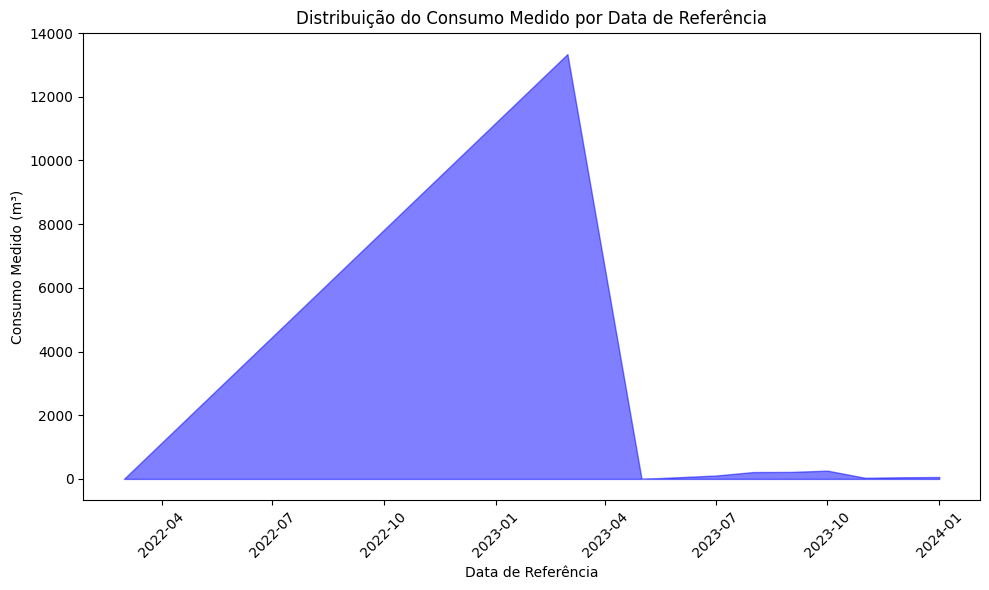

In [30]:
ALL_COLUMNS_CONSUMO_GERAL_UMA_MATRICULA = dataframe_pj_premissa[dataframe_pj_premissa['MATRICULA'] == 17132023.0]
ALL_COLUMNS_CONSUMO_GERAL_UMA_MATRICULA['REFERENCIA'] = pd.to_datetime(dataframe_pj_premissa['REFERENCIA'])

# Agrupando o consumo por data de referência
df_agrupado = ALL_COLUMNS_CONSUMO_GERAL_UMA_MATRICULA.groupby('REFERENCIA')['CONS_MEDIDO'].sum().reset_index()

# Plotando a distribuição do consumo medido por data
# Plotando a distribuição do consumo medido por data utilizando gráfico de área
plt.figure(figsize=(10, 6))
plt.fill_between(df_agrupado['REFERENCIA'], df_agrupado['CONS_MEDIDO'], color='blue', alpha=0.5)
plt.title('Distribuição do Consumo Medido por Data de Referência')
plt.xlabel('Data de Referência')
plt.ylabel('Consumo Medido (m³)')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [31]:
import plotly.express as px

fig = px.line(df_agrupado, x='REFERENCIA', y='CONS_MEDIDO',
              title='Distribuição do Consumo Medido por Data de Referência - Matrícula 17719490',
              labels={'REFERENCIA': 'Data de Referência', 'CONS_MEDIDO': 'Consumo Medido (m³)'})

# Ajustando o layout do gráfico
fig.update_layout(xaxis_title='Data de Referência',
                  yaxis_title='Consumo Medido (m³)',
                  xaxis_tickangle=-45)

# Exibir o gráfico
fig.show()

### Processo de One Hot Encoding para as Colunas, as quais serão as features para o nosso modelo

In [ ]:
dataframe_pj_premissa = pd.get_dummies(dataframe_pj_premissa, columns=['TIPO_LIGACAO', 'DSC_OCORRENCIA', 'STA_TROCA', 'STA_ACEITA_LEITURA', 'ECO_COMERCIAL', 'ECO_INDUSTRIAL', 'ECO_PUBLICA'], dtype='int')

In [ ]:
dataframe_pj_premissa

,REFERENCIA,MATRICULA,CONS_MEDIDO,CATEGORIA,SUB_CATEGORIA,VOLUME_ESTIMADO,VOLUME_ESTIMADO_ACUM,FATURADO_MEDIA,COD_LATITUDE,COD_LONGITUDE,...,ECO_COMERCIAL_124.0,ECO_COMERCIAL_149.0,ECO_COMERCIAL_175.0,ECO_COMERCIAL_363.0,ECO_INDUSTRIAL_0.0,ECO_INDUSTRIAL_1.0,ECO_INDUSTRIAL_2.0,ECO_INDUSTRIAL_10.0,ECO_PUBLICA_0.0,ECO_PUBLICA_1.0
312,2024-01-01,17835219.0,0.0,COMERCIAL,COMERCIAL,0.0,0.0,NaN,-20.492174,-54.601803,...,0,0,0,0,1,0,0,0,1,0
313,2024-01-01,17835219.0,0.0,COMERCIAL,COMERCIAL,0.0,0.0,NaN,-20.492174,-54.601803,...,0,0,0,0,1,0,0,0,1,0
314,2024-01-01,17835219.0,0.0,COMERCIAL,COMERCIAL,0.0,0.0,NaN,-20.492174,-54.601803,...,0,0,0,0,1,0,0,0,1,0
315,2024-01-01,17775660.0,0.0,COMERCIAL,COMERCIAL,0.0,0.0,NaN,-20.467023,-54.615593,...,0,0,0,0,1,0,0,0,1,0
316,2024-01-01,17775660.0,0.0,COMERCIAL,COMERCIAL,0.0,0.0,NaN,-20.467023,-54.615593,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20035780,2022-03-01,17106914.0,0.0,COMERCIAL,COMERCIAL,6.0,12.0,MEDIA,-20.472279,-54.616689,...,0,0,0,0,1,0,0,0,1,0
20035807,2022-03-01,17197853.0,0.0,COMERCIAL,COMERCIAL,5.0,62.0,MEDIA,-20.449548,-54.616009,...,0,0,0,0,1,0,0,0,1,0
20035808,2022-03-01,17197853.0,0.0,COMERCIAL,COMERCIAL,5.0,62.0,MEDIA,-20.449548,-54.616009,...,0,0,0,0,1,0,0,0,1,0
20035817,2022-03-01,17132023.0,0.0,COMERCIAL,COMERCIAL,2.0,1316.0,MEDIA,-20.464203,-54.615575,...,0,0,0,0,1,0,0,0,1,0


In [ ]:
fraudes.columns

Index(['TIPOOS', 'ANOOS', 'IDOSP', 'ANOMES', 'MATRICULA', 'OS', 'SERVICO',
       'DESCRICAO', 'COD_GRUPO', 'SETOR', 'DATACONCLUSAO', 'STATUS', 'ATRASO',
       'DESCRSETOR', 'DESCRSETORSOLICITANTE', 'ID_CONTRATO', 'CD_CONTRATO',
       'CD_SUB_REGIAO', 'CD_REGIAO', 'FL_PRINCIPAL', 'DS_SERVICO_SOLICITADO',
       'FL_EXECUTADO', 'DT_SERVICO', 'DT_FECHAMENTO', 'PARECER_EXECUCAO'],
      dtype='object')

In [ ]:
def cortandoDataFraude(df, startAno, endAno):
    start_date = f'{startAno}'
    end_date = f'{endAno}'

    df['ANOOS'] = pd.to_datetime(df['ANOOS'], format='%Y')

    # Filtrando o DataFrame pela janela de tempo
    mask = (df['ANOOS'] >= start_date) & (df['ANOOS'] <= end_date)
    df_filtered = df.loc[mask]

    return df_filtered

fraudes = cortandoDataFraude(fraudes, 2022, 2024)

In [ ]:
fraudes

,TIPOOS,ANOOS,IDOSP,ANOMES,MATRICULA,OS,SERVICO,DESCRICAO,COD_GRUPO,SETOR,...,ID_CONTRATO,CD_CONTRATO,CD_SUB_REGIAO,CD_REGIAO,FL_PRINCIPAL,DS_SERVICO_SOLICITADO,FL_EXECUTADO,DT_SERVICO,DT_FECHAMENTO,PARECER_EXECUCAO
0,Desdobro,2023-01-01,230101031796,11/23,17229588,1031796,110013,IRREGULARIDADE IDENTIFICADA,0.0,80.0,...,41,41,0.0,0.0,0,VISTORIA DE IRREGULARIDADE - IMPEDIMENTO DE AC...,1,2023-11-06 0:00:00,2023-11-06 11:07:02,NaN
1,Desdobro,2024-01-01,240100141765,02/24,17804014,141765,110013,IRREGULARIDADE IDENTIFICADA,0.0,70.0,...,41,41,0.0,0.0,0,VISTORIA DE IRREGULARIDADE,1,2024-02-13 0:00:00,2024-02-13 15:59:01,421.0
2,Desdobro,2024-01-01,240100021314,01/24,17234771,21314,110013,IRREGULARIDADE IDENTIFICADA,0.0,96.0,...,41,41,0.0,0.0,0,VISTORIA DE IRREGULARIDADE IDENTIFICADA - LEITURA,1,2024-01-08 0:00:00,2024-01-08 15:45:46,413.0
3,Desdobro,2023-01-01,230101217142,12/23,17837656,1217142,110013,IRREGULARIDADE IDENTIFICADA,0.0,1.0,...,41,41,0.0,0.0,0,VISTORIA DE IRREGULARIDADE SUSPEITA - LEITURISTA,1,2024-01-03 0:00:00,2024-01-03 15:40:12,NaN
4,Desdobro,2024-01-01,240100077627,01/24,17722316,77627,110013,IRREGULARIDADE IDENTIFICADA,0.0,84.0,...,41,41,0.0,0.0,0,VISTORIA DE IRREGULARIDADE - IMPEDIMENTO DE AC...,1,2024-01-24 0:00:00,2024-01-24 08:53:18,421.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225948,OsOnline,2023-01-01,230100567691,07/23,17117921,100567691,110013,IRREGULARIDADE IDENTIFICADA,4.0,45.0,...,53,18,1.0,1.0,0,VISTORIA DE IRREGULARIDADE - IMPEDIMENTO DE AC...,1,2023-07-01 14:08:30,2023-07-01 14:08:43,0.0
225993,OsOnline,2022-01-01,220100065876,01/22,17511826,100065876,110013,IRREGULARIDADE IDENTIFICADA,4.0,76.0,...,53,18,1.0,1.0,0,VISTORIA DE IRREGULARIDADE - DENUNCIA,1,2022-01-21 10:38:13,2022-01-21 10:38:23,NaN
225994,OsOnline,2022-01-01,220100450752,05/22,17920302,100450752,110013,IRREGULARIDADE IDENTIFICADA,4.0,3.0,...,53,18,2.0,1.0,0,VISTORIA DE IRREGULARIDADE IDENTIFICADA - LEITURA,1,2022-05-10 16:51:43,2022-05-10 16:52:03,NaN
225995,OsOnline,2022-01-01,220101353952,12/22,17801545,101353952,110013,IRREGULARIDADE IDENTIFICADA,4.0,2.0,...,53,18,2.0,1.0,0,VISTORIA POS CORTE,1,2022-12-30 11:52:39,2022-12-30 12:22:23,NaN


In [ ]:
dataframe_fraudes_premissa = fraudes[['MATRICULA', 'DESCRICAO']].drop_duplicates()
dataframe_fraudes_premissa = pd.get_dummies(dataframe_fraudes_premissa, columns=['DESCRICAO'], dtype='int')

In [ ]:
dataframe_fraudes_premissa['DESCRICAO_IRREGULARIDADE IDENTIFICADA'].unique()

array([1])

In [ ]:
len(dataframe_fraudes_premissa)

85460

In [ ]:
dataframe_pj_premissa = pd.merge(dataframe_pj_premissa, dataframe_fraudes_premissa, on='MATRICULA', how='left')

In [ ]:
# dataframe_pj_premissa.drop_duplicates(subset="MATRICULA", keep='first')
dataframe_pj_premissa.dropna(subset="REFERENCIA")

,REFERENCIA,MATRICULA,CONS_MEDIDO,CATEGORIA,SUB_CATEGORIA,VOLUME_ESTIMADO,VOLUME_ESTIMADO_ACUM,FATURADO_MEDIA,COD_LATITUDE,COD_LONGITUDE,...,ECO_COMERCIAL_149.0,ECO_COMERCIAL_175.0,ECO_COMERCIAL_363.0,ECO_INDUSTRIAL_0.0,ECO_INDUSTRIAL_1.0,ECO_INDUSTRIAL_2.0,ECO_INDUSTRIAL_10.0,ECO_PUBLICA_0.0,ECO_PUBLICA_1.0,DESCRICAO_IRREGULARIDADE IDENTIFICADA
0,2024-01-01,17835219.0,0.0,COMERCIAL,COMERCIAL,0.0,0.0,NaN,-20.492174,-54.601803,...,0,0,0,1,0,0,0,1,0,1.0
1,2024-01-01,17835219.0,0.0,COMERCIAL,COMERCIAL,0.0,0.0,NaN,-20.492174,-54.601803,...,0,0,0,1,0,0,0,1,0,1.0
2,2024-01-01,17835219.0,0.0,COMERCIAL,COMERCIAL,0.0,0.0,NaN,-20.492174,-54.601803,...,0,0,0,1,0,0,0,1,0,1.0
3,2024-01-01,17775660.0,0.0,COMERCIAL,COMERCIAL,0.0,0.0,NaN,-20.467023,-54.615593,...,0,0,0,1,0,0,0,1,0,NaN
4,2024-01-01,17775660.0,0.0,COMERCIAL,COMERCIAL,0.0,0.0,NaN,-20.467023,-54.615593,...,0,0,0,1,0,0,0,1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1707959,2022-03-01,17106914.0,0.0,COMERCIAL,COMERCIAL,6.0,12.0,MEDIA,-20.472279,-54.616689,...,0,0,0,1,0,0,0,1,0,1.0
1707960,2022-03-01,17197853.0,0.0,COMERCIAL,COMERCIAL,5.0,62.0,MEDIA,-20.449548,-54.616009,...,0,0,0,1,0,0,0,1,0,1.0
1707961,2022-03-01,17197853.0,0.0,COMERCIAL,COMERCIAL,5.0,62.0,MEDIA,-20.449548,-54.616009,...,0,0,0,1,0,0,0,1,0,1.0
1707962,2022-03-01,17132023.0,0.0,COMERCIAL,COMERCIAL,2.0,1316.0,MEDIA,-20.464203,-54.615575,...,0,0,0,1,0,0,0,1,0,1.0


In [ ]:
dataframe_pj_premissa = dataframe_pj_premissa.dropna(subset="COD_LATITUDE")
dataframe_pj_premissa = dataframe_pj_premissa.dropna(subset="COD_LONGITUDE")

## Clusterização

### Agrupamento dos clusteres por Latitude e Longitude

Aqui removendo os outliers nas colunas de latitude e longitude

In [ ]:
def remove_rows_with_column_value_greater_than_one(df, column_names):
    condition = (df[column_names] > -10).any(axis=1)

    df_filtered = df[~condition]

    return df_filtered

dataframe_pj_premissa = remove_rows_with_column_value_greater_than_one(dataframe_pj_premissa, ['COD_LATITUDE', 'COD_LONGITUDE'])

In [ ]:
def plotar(n_clusters):

  df_temp = dataframe_pj_premissa.copy()
  kmeans = KMeans(n_clusters=n_clusters, random_state=42)
  df_temp['cluster'] = kmeans.fit_predict(dataframe_pj_premissa[['COD_LATITUDE', 'COD_LONGITUDE']])

  # visualizando
  plt.figure(figsize=(10, 6))
  plt.scatter(dataframe_pj_premissa['COD_LONGITUDE'], dataframe_pj_premissa['COD_LATITUDE'], c=df_temp['cluster'], cmap='viridis', marker='o', s=100)
  plt.title(f"K-Means Clustering com {n_clusters} Clusters")
  plt.xlabel("Longitude")
  plt.ylabel("Latitude")
  plt.show()


# visulizar clusters do range de 2 para 17
# for x in range(2, 17):
#   print()
#   plotar(x)

In [ ]:
kmeans = KMeans(n_clusters=20, random_state=42)
dataframe_pj_premissa['cluster'] = kmeans.fit_predict(dataframe_pj_premissa[['COD_LATITUDE', 'COD_LONGITUDE']])

In [ ]:
dataframe_pj_premissa = dataframe_pj_premissa.drop(columns=['COD_LATITUDE', 'COD_LONGITUDE'])

In [ ]:
dataframe_pj_premissa = pd.get_dummies(dataframe_pj_premissa, columns = ['cluster'], dtype=int)

### Normalizando com o Robust Scaler

O RobustScaler é uma técnica de normalização usada para transformar dados. Ele é útil especialmente quando os dados contêm outliers, ou seja, valores atípicos que podem distorcer (neste caso o Consumo e o Volume) os resultados de outras técnicas de escalonamento, como StandardScaler ou MinMaxScaler.

O RobustScaler transforma os dados subtraindo a mediana e dividindo pela amplitude interquartil (IQR, Interquartile Range). A mediana é o valor do ponto médio quando os dados são ordenados, e o IQR é a diferença entre o terceiro quartil (75º percentil) e o primeiro quartil (25º percentil).

Esse método é menos sensível a outliers porque, ao contrário da média e do desvio padrão (usados pelo StandardScaler), a mediana e o IQR não são afetados por valores extremos.

In [ ]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

dataframe_pj_premissa[['CONS_MEDIDO']] = scaler.fit_transform(dataframe_pj_premissa[['CONS_MEDIDO']])
dataframe_pj_premissa[['VOLUME_ESTIMADO']] = scaler.fit_transform(dataframe_pj_premissa[['VOLUME_ESTIMADO']])

In [ ]:
pivoted_df = pd.pivot_table(
    dataframe_pj_premissa,
    index='MATRICULA',
    columns='REFERENCIA',
    values=['CONS_MEDIDO', 'VOLUME_ESTIMADO', 'Precipitação', 'Temperatura Média'],
    aggfunc='sum'
)

pivoted_df.columns = ['_'.join([str(col[0]), col[1].strftime('%Y-%m-%d')]).strip() for col in pivoted_df.columns.values]
pivoted_df = pivoted_df.reset_index()

pivoted_df.head()

,MATRICULA,CONS_MEDIDO_2022-01-01,CONS_MEDIDO_2022-02-01,CONS_MEDIDO_2022-03-01,CONS_MEDIDO_2022-04-01,CONS_MEDIDO_2022-05-01,CONS_MEDIDO_2022-06-01,CONS_MEDIDO_2022-07-01,CONS_MEDIDO_2022-08-01,CONS_MEDIDO_2022-09-01,...,VOLUME_ESTIMADO_2023-04-01,VOLUME_ESTIMADO_2023-05-01,VOLUME_ESTIMADO_2023-06-01,VOLUME_ESTIMADO_2023-07-01,VOLUME_ESTIMADO_2023-08-01,VOLUME_ESTIMADO_2023-09-01,VOLUME_ESTIMADO_2023-10-01,VOLUME_ESTIMADO_2023-11-01,VOLUME_ESTIMADO_2023-12-01,VOLUME_ESTIMADO_2024-01-01
0,17075331.0,1.615385,NaN,2.461538,0.769231,0.461538,0.615385,0.461538,0.769231,0.307692,...,0.0,NaN,-14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,17075333.0,-0.923077,-0.615385,-0.615385,-0.615385,-0.615385,-0.615385,-0.615385,-0.615385,-0.615385,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,17075335.0,0.461538,-0.307692,-0.307692,0.153846,-0.615385,-0.461538,-0.307692,-0.461538,-0.615385,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
3,17075337.0,-0.461538,-0.153846,-0.307692,-0.461538,0.461538,-0.153846,0.000000,0.000000,0.307692,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,17075338.0,18.692308,1.538462,1.384615,2.153846,2.307692,1.076923,1.076923,1.384615,1.384615,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
len(pivoted_df)

42623

### Atribuição de cada uma das variáveis categóricas ao dataframe com o consumo e volume históricos

- É importante citar aqui que atribuímos a premissa que a primeira definição de tipo de ligação, descrição e os outros utilizados, serão os que tomaremos como base para inferência dentro do modelo

In [ ]:
tipo_ligacao = dataframe_pj_premissa[['MATRICULA','TIPO_LIGACAO_Consumo Fixo', 'TIPO_LIGACAO_Hidrometrado']].drop_duplicates(subset='MATRICULA', keep='first')
pivoted_df = pivoted_df.merge(tipo_ligacao, on='MATRICULA', how='left').fillna(0)

In [ ]:
descricao_ocorrencia = dataframe_pj_premissa[['MATRICULA','DSC_OCORRENCIA_MEDIDOR NÃO LOCALIZADO', 'DSC_OCORRENCIA_MEDIDOR RETIRADO/FURTADO', 'DSC_OCORRENCIA_NORMAL']].drop_duplicates(subset='MATRICULA', keep='first')
pivoted_df = pivoted_df.merge(descricao_ocorrencia, on='MATRICULA', how='left').fillna(0)

In [ ]:
fraude_ou_não = dataframe_pj_premissa[['MATRICULA','DESCRICAO_IRREGULARIDADE IDENTIFICADA']].drop_duplicates(subset='MATRICULA', keep='first')
pivoted_df = pivoted_df.merge(fraude_ou_não, on='MATRICULA', how='left').fillna(0)

In [ ]:
dataframe_pj_premissa.columns.values

array(['REFERENCIA', 'MATRICULA', 'CONS_MEDIDO', 'CATEGORIA',
       'SUB_CATEGORIA', 'VOLUME_ESTIMADO', 'VOLUME_ESTIMADO_ACUM',
       'FATURADO_MEDIA', 'MES', 'Temperatura Média', 'Temperatura Mínima',
       'Temperatura Máxima', 'Precipitação', 'Neve', 'Direção do Vento',
       'Velocidade do Vento', 'Rajada Máxima de Vento',
       'Pressão Atmosférica', 'Insolação', 'TIPO_LIGACAO_Consumo Fixo',
       'TIPO_LIGACAO_Hidrometrado',
       'DSC_OCORRENCIA_CAIXA DE PROTEÇÃO FECHADA',
       'DSC_OCORRENCIA_HIDRÔMETRO COM CÚPULA VIRADA/TAMPADA',
       'DSC_OCORRENCIA_IMÓVEL DESOCUPADO',
       'DSC_OCORRENCIA_LEITURA COLETADA PELO CLIENTE',
       'DSC_OCORRENCIA_MEDIDOR NÃO LOCALIZADO',
       'DSC_OCORRENCIA_MEDIDOR RETIRADO/FURTADO', 'DSC_OCORRENCIA_NORMAL',
       'STA_TROCA_N', 'STA_TROCA_S', 'STA_ACEITA_LEITURA_N',
       'STA_ACEITA_LEITURA_S', 'ECO_COMERCIAL_0.0', 'ECO_COMERCIAL_1.0',
       'ECO_COMERCIAL_2.0', 'ECO_COMERCIAL_3.0', 'ECO_COMERCIAL_4.0',
       'ECO_COMERCIAL

In [ ]:
eco_columns = dataframe_pj_premissa.filter(regex='^ECO_[CIP]').columns
eco_columns

Index(['ECO_COMERCIAL_0.0', 'ECO_COMERCIAL_1.0', 'ECO_COMERCIAL_2.0',
       'ECO_COMERCIAL_3.0', 'ECO_COMERCIAL_4.0', 'ECO_COMERCIAL_5.0',
       'ECO_COMERCIAL_6.0', 'ECO_COMERCIAL_7.0', 'ECO_COMERCIAL_8.0',
       'ECO_COMERCIAL_9.0', 'ECO_COMERCIAL_10.0', 'ECO_COMERCIAL_11.0',
       'ECO_COMERCIAL_12.0', 'ECO_COMERCIAL_13.0', 'ECO_COMERCIAL_14.0',
       'ECO_COMERCIAL_15.0', 'ECO_COMERCIAL_16.0', 'ECO_COMERCIAL_17.0',
       'ECO_COMERCIAL_18.0', 'ECO_COMERCIAL_21.0', 'ECO_COMERCIAL_22.0',
       'ECO_COMERCIAL_23.0', 'ECO_COMERCIAL_24.0', 'ECO_COMERCIAL_27.0',
       'ECO_COMERCIAL_29.0', 'ECO_COMERCIAL_33.0', 'ECO_COMERCIAL_36.0',
       'ECO_COMERCIAL_40.0', 'ECO_COMERCIAL_47.0', 'ECO_COMERCIAL_48.0',
       'ECO_COMERCIAL_51.0', 'ECO_COMERCIAL_54.0', 'ECO_COMERCIAL_61.0',
       'ECO_COMERCIAL_62.0', 'ECO_COMERCIAL_70.0', 'ECO_COMERCIAL_80.0',
       'ECO_COMERCIAL_91.0', 'ECO_COMERCIAL_98.0', 'ECO_COMERCIAL_101.0',
       'ECO_COMERCIAL_124.0', 'ECO_COMERCIAL_149.0', 'ECO_CO

In [ ]:
eco = dataframe_pj_premissa[['MATRICULA'] + list(eco_columns)].drop_duplicates(subset='MATRICULA', keep='first')

pivoted_df = pivoted_df.merge(eco, on='MATRICULA', how='left').fillna(0)

In [ ]:
dataframe_pj_premissa.columns.values

array(['REFERENCIA', 'MATRICULA', 'CONS_MEDIDO', 'CATEGORIA',
       'SUB_CATEGORIA', 'VOLUME_ESTIMADO', 'VOLUME_ESTIMADO_ACUM',
       'FATURADO_MEDIA', 'MES', 'Temperatura Média', 'Temperatura Mínima',
       'Temperatura Máxima', 'Precipitação', 'Neve', 'Direção do Vento',
       'Velocidade do Vento', 'Rajada Máxima de Vento',
       'Pressão Atmosférica', 'Insolação', 'TIPO_LIGACAO_Consumo Fixo',
       'TIPO_LIGACAO_Hidrometrado',
       'DSC_OCORRENCIA_CAIXA DE PROTEÇÃO FECHADA',
       'DSC_OCORRENCIA_HIDRÔMETRO COM CÚPULA VIRADA/TAMPADA',
       'DSC_OCORRENCIA_IMÓVEL DESOCUPADO',
       'DSC_OCORRENCIA_LEITURA COLETADA PELO CLIENTE',
       'DSC_OCORRENCIA_MEDIDOR NÃO LOCALIZADO',
       'DSC_OCORRENCIA_MEDIDOR RETIRADO/FURTADO', 'DSC_OCORRENCIA_NORMAL',
       'STA_TROCA_N', 'STA_TROCA_S', 'STA_ACEITA_LEITURA_N',
       'STA_ACEITA_LEITURA_S', 'ECO_COMERCIAL_0.0', 'ECO_COMERCIAL_1.0',
       'ECO_COMERCIAL_2.0', 'ECO_COMERCIAL_3.0', 'ECO_COMERCIAL_4.0',
       'ECO_COMERCIAL

In [ ]:
clusters = dataframe_pj_premissa[['MATRICULA','cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4',
       'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9',
       'cluster_10', 'cluster_11', 'cluster_12', 'cluster_13',
       'cluster_14', 'cluster_15', 'cluster_16', 'cluster_17',
       'cluster_18', 'cluster_19']].drop_duplicates(subset='MATRICULA', keep='first')
pivoted_df = pivoted_df.merge(clusters, on='MATRICULA', how='left').fillna(0)

In [ ]:
pivoted_df = pivoted_df.fillna(0)

In [ ]:
pivoted_df

,MATRICULA,CONS_MEDIDO_2022-01-01,CONS_MEDIDO_2022-02-01,CONS_MEDIDO_2022-03-01,CONS_MEDIDO_2022-04-01,CONS_MEDIDO_2022-05-01,CONS_MEDIDO_2022-06-01,CONS_MEDIDO_2022-07-01,CONS_MEDIDO_2022-08-01,CONS_MEDIDO_2022-09-01,...,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,cluster_18,cluster_19
0,17075331.0,1.615385,0.000000,2.461538,0.769231,0.461538,0.615385,0.461538,0.769231,0.307692,...,0,0,0,0,0,1,0,0,0,0
1,17075333.0,-0.923077,-0.615385,-0.615385,-0.615385,-0.615385,-0.615385,-0.615385,-0.615385,-0.615385,...,0,0,0,0,0,1,0,0,0,0
2,17075335.0,0.461538,-0.307692,-0.307692,0.153846,-0.615385,-0.461538,-0.307692,-0.461538,-0.615385,...,0,0,0,0,0,1,0,0,0,0
3,17075337.0,-0.461538,-0.153846,-0.307692,-0.461538,0.461538,-0.153846,0.000000,0.000000,0.307692,...,0,0,0,0,0,1,0,0,0,0
4,17075338.0,18.692308,1.538462,1.384615,2.153846,2.307692,1.076923,1.076923,1.384615,1.384615,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42618,17992482.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,1,0
42619,17992531.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,1,0,0,0
42620,17992577.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,1,0,0,0,0,0,0,0,0
42621,17992597.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
np.unique(pivoted_df['DESCRICAO_IRREGULARIDADE IDENTIFICADA'].values, return_counts=True)

(array([0., 1.]), array([33896,  8727]))

In [ ]:
pivoted_df.to_parquet('/content/drive/Shareddrives/LeakSeeker/pre_processado_pj.parquet')

## Identificação dos clusters por gráfico

In [ ]:
# import folium
# from sklearn.cluster import KMeans

# centroides = kmeans.cluster_centers_

# # Criar um mapa centrado nas coordenadas médias do dataset
# media_lat = df_sem_linhas['COD_LATITUDE'].mean()
# media_long = df_sem_linhas['COD_LONGITUDE'].mean()
# mapa = folium.Map(location=[media_lat, media_long], zoom_start=12)

# # Adicionar os pontos dos dados ao mapa
# for i, row in df_sem_linhas.iterrows():
#     folium.CircleMarker(location=[row['COD_LATITUDE'], row['COD_LONGITUDE']],
#                         radius=5,
#                         color='blue',
#                         fill=True,
#                         fill_color='blue',
#                         fill_opacity=0.6).add_to(mapa)

# # Adicionar os centróides dos clusters ao mapa com o número do cluster
# for i, centroide in enumerate(centroides):
#     folium.Marker(location=[centroide[0], centroide[1]],
#                   popup=f'Cluster {i}',  # Exibe o número do cluster
#                   icon=folium.DivIcon(html=f"""<div style="font-size: 12pt; color : red">{i}</div>""")).add_to(mapa)

# # Mostrar o mapa
# mapa